Los Modelos Ocultos de Markov (HMM, por sus siglas en inglés) constituyen una categoría especializada de modelos estadísticos generativos que se emplean para inferir la distribución de probabilidad subyacente de una serie temporal de observaciones. Estos modelos son particularmente útiles en aplicaciones de reconocimiento de patrones, procesamiento del lenguaje natural (PLN), y aprendizaje automático. Los HMM presuponen la existencia de un proceso estocástico de Markov latente, el cual no es directamente observable. La inferencia sobre este proceso latente se realiza mediante un conjunto de observaciones secuenciales, que son modeladas como emisiones generadas por los estados ocultos del proceso de Markov.

Matemáticamente, un Modelo Oculto de Markov (HMM) se define mediante un conjunto de componentes que incluyen:

1. Un conjunto finito de $N$ estados ocultos, denotado como $\mathcal{S} = \{ s_1, s_2, \ldots, s_N \}$.
2. Un conjunto finito de $M$ observaciones distintas, denotado como $\mathcal{O} = \{ o_1, o_2, \ldots, o_M \}$.
3. Una matriz de transición de estados $A$, donde $a_{ij}$ representa la probabilidad de transición del estado $s_i$ al estado $s_j$, es decir, $a_{ij} = P(q_{t+1} = s_j | q_t = s_i)$.
4. Una matriz de emisión $B$, donde $b_{i}(k)$ es la probabilidad de emitir la observación $o_k$ cuando el sistema se encuentra en el estado $s_i$, es decir, $b_{i}(k) = P(o_t = o_k | q_t = s_i)$.
5. Una distribución inicial $\pi$, donde $\pi_i$ es la probabilidad de que el estado $s_i$ sea el estado inicial, es decir, $\pi_i = P(q_1 = s_i)$.

La secuencia de estados ocultos $q = (q_1, q_2, \ldots, q_T)$ y la secuencia de observaciones $o = (o_1, o_2, \ldots, o_T)$ se relacionan a través del modelo, y la tarea consiste en resolver problemas como la estimación de la secuencia más probable de estados dado un conjunto de observaciones, comúnmente resuelto mediante el algoritmo de Viterbi, o estimar los parámetros del modelo dado un conjunto de observaciones, típicamente resuelto mediante el algoritmo Baum-Welch.



*Bibliotecas necesarias*

* [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/index.html)
* [pandas](https://pandas.pydata.org/)
* [numpy](https://numpy.org/)
* [matplotlib](https://matplotlib.org/)
* [seaborn](https://seaborn.pydata.org/)
* [scipy](https://www.scipy.org/)

In [37]:
# Para instalar hmmlearn, descomentar la siguiente linea y ejecutar
# !pip install hmmlearn
!ls

analysis2.csv	  histogramas_subestados_movimiento.png  states_time2.png
animation_mpl.py  histograma_velocidad.png		 states_time.png
data		  hmm_analysis_v2.ipynb
Fig3.png	  README.md


En las siguientes celdas usaremos datos provenientes de DeepLabCut, en donde se registraron las posiciones de la cabeza de un ratón en un campo abierto. El objetivo es usar HMM para inferir los estados ocultos del ratón, a partir de las posiciones de la cabeza. En particular, demostraremos cómo se puede inferir tres posibles estados: quieto, caminando y corriendo. Los observables $o_M$ serán las posiciones de la cabeza del ratón, y los estados ocultos $s_N$ serán los estados de movimiento del ratón.

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hmmlearn.hmm as hmm
import os
import seaborn as sns
from scipy.signal import savgol_filter
import numpy as np

# Load the data
os.chdir(os.getcwd())
df = pd.read_csv('data/data_select.csv')
df.head()


,time,hx.m,hy.m,distance,subject,treatment,date
0,0.041667,20.662596,23.558278,0.000000,TC13,CTRL,MAR_3_AM
1,0.083333,19.844052,23.632344,0.821888,TC13,CTRL,MAR_3_AM
2,0.125000,18.955256,23.722375,0.893344,TC13,CTRL,MAR_3_AM
3,0.166667,18.004624,23.825303,0.956189,TC13,CTRL,MAR_3_AM
4,0.208333,17.002847,23.937036,1.007988,TC13,CTRL,MAR_3_AM


Creación de características para el análisis de los datos de los HMMs. Se crean las siguientes características:

- Vectores de velocidad y aceleración en $x$ y $y$, usando la función gradient de numpy.
$$
\begin{align}
\vec{v}_x= \frac{\partial x}{\partial t} \hat{x} \\
\vec{v}_y= \frac{\partial y}{\partial t} \hat{y} \\
\vec{a}_x= \frac{\partial^2 x}{\partial t^2} \hat{x} \\
\vec{a}_y= \frac{\partial^2 y}{\partial t^2} \hat{y}
\end{align}
$$
- Rapidez, computada como la norma del vector velocidad.
$$
\begin{align}
v = \sqrt{v_x^2 + v_y^2}
\end{align}
$$
- Magnitud de la aceleración, computada como la norma del vector aceleración.
$$
\begin{align}
a = \sqrt{a_x^2 + a_y^2}
\end{align}
$$
- Ángulo de giro, computado como el ángulo entre el vector velocidad y el eje $x$.
$$
\begin{align}
\theta = \arctan{\frac{v_y}{v_x}}
\end{align}
$$
- Curvatura, computada como la norma del vector aceleración dividida por la rapidez al cuadrado.

$$
\begin{align}
\kappa = \frac{{v_x \cdot a_y - v_y \cdot a_x}}{{(v_x^2 + v_y^2)^{1.5}}}
\end{align}
$$

- Dirección, como el ángulo del vector velocidad con respecto al eje $x$.
$$
\begin{align}
\phi = \arctan{\frac{v_y}{v_x}}
\end{align}
$$

- Cambio de dirección, como la diferencia entre el ángulo de giro en el tiempo $t$ y el ángulo de giro en el tiempo $t-1$.
$$
\begin{align}
\Delta \theta = \theta_t - \theta_{t-1}
\end{align}
$$




In [39]:

# Define the window length and polynomial order for the Savitzky-Golay filter
window_length, poly_order = 91, 3

# Apply the Savitzky-Golay filter to smooth the data
df['hx.m_smooth'] = savgol_filter(df['hx.m'], window_length, poly_order)
df['hy.m_smooth'] = savgol_filter(df['hy.m'], window_length, poly_order)

# Compute the velocity
df['vx.m/s'] = np.gradient(df['hx.m_smooth'], df['time'])
df['vy.m/s'] = np.gradient(df['hy.m_smooth'], df['time'])

# Compute the acceleration
df['ax.m/s^2'] = np.gradient(df['vx.m/s'], df['time'])
df['ay.m/s^2'] = np.gradient(df['vy.m/s'], df['time'])

# Compute the speed
df['speed.m/s'] = np.sqrt(df['vx.m/s']**2 + df['vy.m/s']**2)
df['log_speed'] = np.log(df['speed.m/s'])
# Compute the acceleration magnitude
df['acceleration.m/s^2'] = np.sqrt(df['ax.m/s^2']**2 + df['ay.m/s^2']**2)
df['log_acceleration'] = np.log(df['acceleration.m/s^2'])

# Compute the turning angle
df['turn_angle.deg'] = np.arctan2(df['ay.m/s^2'], df['ax.m/s^2']) * 180 / np.pi

# Compute the curvature
df['curvature.1/m'] = (df['vx.m/s'] * df['ay.m/s^2'] - df['vy.m/s']
                       * df['ax.m/s^2']) / (df['vx.m/s']**2 + df['vy.m/s']**2)**1.5
# Compute the direction
df['direction'] = np.degrees(np.arctan2(df['vy.m/s'], df['vx.m/s']))

# Compute the change in direction
df['change_in_direction'] = np.diff(np.unwrap(df['direction']), prepend=df['direction'].iloc[0])

# Compute the jerk
df['jerk_x.m/s^3'] = np.gradient(df['ax.m/s^2'], df['time'])
df['jerk_y.m/s^3'] = np.gradient(df['ay.m/s^2'], df['time'])

# Compute the jerk magnitude
df['jerk.m/s^3'] = np.sqrt(df['jerk_x.m/s^3']**2 + df['jerk_y.m/s^3']**2)


df.head()


,time,hx.m,hy.m,distance,subject,treatment,date,hx.m_smooth,hy.m_smooth,vx.m/s,...,log_speed,acceleration.m/s^2,log_acceleration,turn_angle.deg,curvature.1/m,direction,change_in_direction,jerk_x.m/s^3,jerk_y.m/s^3,jerk.m/s^3
0,0.041667,20.662596,23.558278,0.000000,TC13,CTRL,MAR_3_AM,20.357475,21.370078,-26.192227,...,3.348563,15.991316,2.772046,-32.649709,0.003297,156.963929,0.000000,158.488356,-101.825453,188.379887
1,0.083333,19.844052,23.632344,0.821888,TC13,CTRL,MAR_3_AM,19.266132,21.834137,-25.631209,...,3.325219,23.840474,3.171385,-32.672817,0.005284,157.193226,0.229297,155.403395,-100.122839,184.864270
2,0.125000,18.955256,23.722375,0.893344,TC13,CTRL,MAR_3_AM,18.221541,22.268239,-24.519884,...,3.277342,31.396648,3.446701,-32.719896,0.008070,157.682872,0.489646,69.989297,-45.804885,83.645616
3,0.166667,18.004624,23.825303,0.956189,TC13,CTRL,MAR_3_AM,17.222808,22.672878,-23.429982,...,3.228104,30.810712,3.427862,-32.792754,0.009242,158.216092,0.533220,-12.339841,6.810455,14.094466
4,0.208333,17.002847,23.937036,1.007988,TC13,CTRL,MAR_3_AM,16.269042,23.048547,-22.361503,...,3.177429,30.224827,3.408664,-32.868435,0.010624,158.798106,0.582014,-12.339841,6.810455,14.094466


Text(0.5, 0, 'Speed (m/s)')

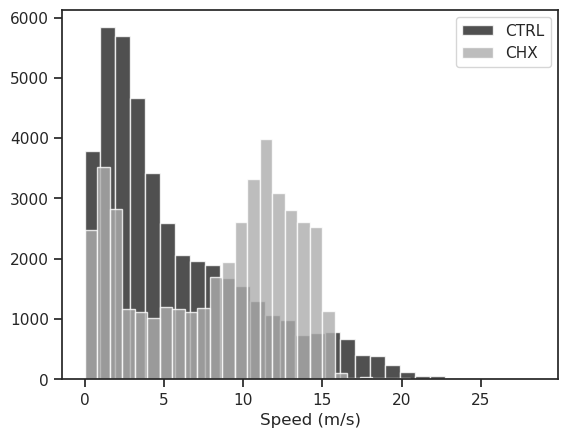

In [40]:
import matplotlib.pyplot as plt

color = ["#242424",
         "#ADADAD"]

# make a dictionary for color mapping by tratement
color_dict = dict(zip(df.treatment.unique(), color))

fig, ax = fig, ax = plt.subplots()

for treatment in ['CTRL', 'CHX']:
    dftmp = df[df.treatment == treatment]
    ax.hist(dftmp['speed.m/s'],
            color=color_dict[treatment],
            label=treatment,
            bins=30, alpha=0.8)
ax.legend()
ax.set_xlabel('Speed (m/s)')

In [41]:
def train_hmm(data, n_states, init='stmc', tol=0.000001, n_iter=150000):
    model = hmm.GaussianHMM(n_components=n_states,
                            covariance_type="full",
                            algorithm='map',
                            params='stmc',
                            init_params=init,
                            random_state=123,
                            tol=tol,
                            n_iter=n_iter)
    model.fit(data)
    return model


def classify_states_hmm(model, data):
    return model.predict(data)


# Define the number of states for HMM
n_states = 3
init_params = "stmc"
# Train and classify states with HMM for each treatment
for treatment, group in df.groupby('treatment'):
    # Select features
    features = group[['speed.m/s', 'acceleration.m/s^2']]

    # Train HMM
    model = train_hmm(features, n_states, init_params)
    # model = train_gmm_hmm(features, n_states)

    # Classify states
    df.loc[df['treatment'] == treatment,
           'state_hmm'] = classify_states_hmm(model, features)

df["state_hmm"].unique()


array([2., 1., 0.])

In [42]:
# summary of speed, acceleration, turning angle, and curvature by state and treatment
df.groupby(['treatment', 'state_hmm']).agg({'speed.m/s': ['mean', 'std'],
                                            'acceleration.m/s^2': ['mean', 'std'],
                                            'jerk.m/s^3': ['mean', 'std'],
                                            'turn_angle.deg': ['mean', 'std'],
                                            'curvature.1/m': ['mean', 'std']})

speed.m/s           acceleration.m/s^2            \
                          mean       std               mean       std   
treatment state_hmm                                                     
CHX       0.0        12.440029  1.840495          18.230578  2.953105   
          1.0         1.497202  0.874711           3.417475  2.117849   
          2.0         9.056187  3.165426          10.675925  4.393916   
CTRL      0.0         1.902613  1.036014           3.587642  1.870419   
          1.0         4.818620  2.087653           7.348263  3.448688   
          2.0        11.498240  4.065130          11.067593  5.777908   

                    jerk.m/s^3            turn_angle.deg              \
                          mean        std           mean         std   
treatment state_hmm                                                    
CHX       0.0        27.781515   8.249504      -2.649837  104.923510   
          1.0         8.483767   5.777442       0.234400  105.686641   
          2.0        16.172019  28.753711       2.463153  108.605067   
CTRL      0.0        14.637339   9.613108       0.825734  102.171754   
          1.0        19.015627  14.142724       6.666111  102.167328   
          2.0        22.330747  33.415010     -10.051472  105.851822   

                    curvature.1/m                
                             mean           std  
treatment state_hmm                              
CHX       0.0           -0.124365      0.095084  
          1.0           -1.466937     41.846324  
          2.0           -0.174944      1.786035  
CTRL      0.0          562.445830  70913.687542  
          1.0           -0.142772     18.229838  
          2.0            0.181484     20.739832

In [43]:
# counts of state by treatment
df.groupby(['treatment', 'state_hmm']).size().reset_index(name='counts')


,treatment,state_hmm,counts
0,CHX,0.0,14675
1,CHX,1.0,10334
2,CHX,2.0,17735
3,CTRL,0.0,16109
4,CTRL,1.0,13269
5,CTRL,2.0,13366


In [44]:
# make a function to classify states as 'stopped' or 'moving', based on the
# mean speed of each state. If the mean of state 0 is greater than the mean of
# state 1, then state 0 is 'moving' and state 1 is 'stopped'. The function
# sould compute the mean BY STATE

def classify_states(df, state_col, speed_col):
    """ Classify states as 'stopped' or 'moving' based on the mean speed of each state
    Args:
        df (dataframe): dataframe with states and speed
        state_col (str): name of the column with states
        speed_col (str): name of the column with speed
    Returns:
        df (dataframe): dataframe with new column 'state_class'
    """
    
    # Compute the mean speed by state
    mean_speed = df.groupby(state_col)[speed_col].mean()
    # Sort the states by mean speed
    states = mean_speed.sort_values().index
    # Make a dictionary for mapping states to 'stopped' or 'moving'
    if len(states) == 2:
        state_dict = dict(zip(states, ['parado', 'lento']))
    elif len(states) == 3:
        state_dict = dict(zip(states, ['parado', 'lento', 'rápido']))
    # Map the states to 'stopped' or 'moving'
    df['state_class'] = df[state_col].map(state_dict)

    return df


# apply by treatement
df = df.groupby('treatment').apply(classify_states, 'state_hmm', 'speed.m/s')
df['state_class'].unique()

array(['rápido', 'lento', 'parado'], dtype=object)

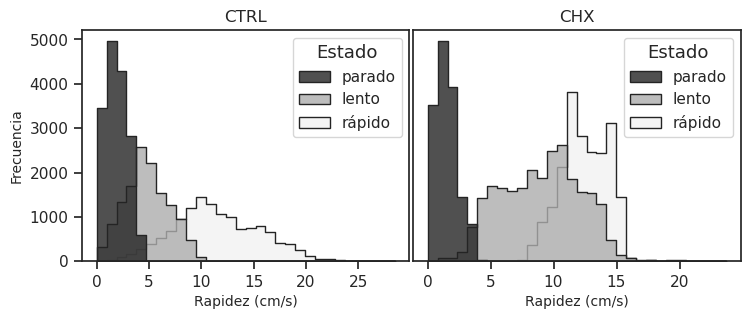

In [68]:
# histogram of speed by state and treatment; make a plot for each treatment

color = ["#242424",
         "#ADADAD"]
color = ["#242424",
         "#F2F2F2",
         "#ADADAD"]
# map the colors to the state_class
color_dict = {'parado': "#242424",
              'lento': "#ADADAD",
              'rápido': "#F2F2F2"}

fig, ax = plt.subplots(1, 2, figsize=(8.5, 3))
plt.subplots_adjust(wspace=0.01)
tr = {'CTRL': 0, 'CHX': 1}

for treatment, group in df.groupby('treatment'):

    plot_hist = sns.histplot(data=group, 
                             x='speed.m/s',
                             hue='state_class',
                             hue_order=['parado', 'lento', 'rápido'],
                             palette=color_dict,
                             element='step',
                             edgecolor='#242424',
                             ax=ax[tr[treatment]],
                             bins=30, alpha=0.8)
    # Getting the legend from the current axes
    legend = plot_hist.get_legend()

    # Setting the title of the legend
    legend.set_title("Estado", prop={'size': 13})

    # Setting the title of the subplot
    ax[tr[treatment]].set_title(treatment)
    ax[tr[treatment]].set_xlabel('Rapidez (cm/s)', fontsize=10)
    if treatment == 'CTRL':
        ax[tr[treatment]].set_ylabel('Frecuencia', fontsize=10)
    else:
        ax[tr[treatment]].set_ylabel('')
        ax[tr[treatment]].set_yticklabels([])
        ax[tr[treatment]].set_yticks([])

# Show the plot after the loop
plt.savefig('histograma_velocidad.png', dpi=600, bbox_inches='tight')
plt.show()


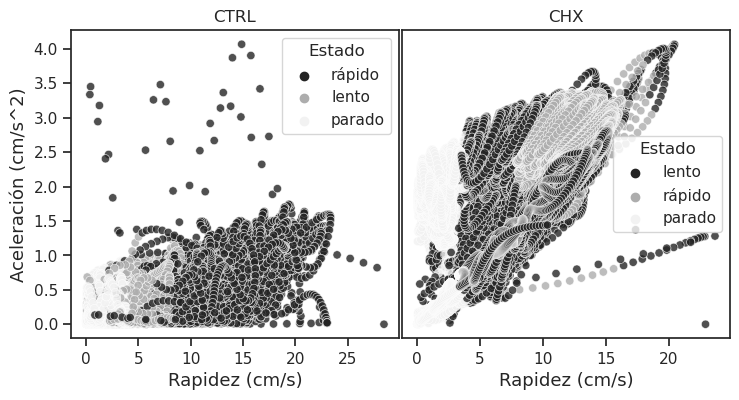

In [46]:
# scatter plot seed vs acceleration, color by state, make a plot for each treatment
color = ["#242424",
          "#ADADAD",
          "#F2F2F2"]
fig, ax = plt.subplots(1, 2, figsize=(8.5, 4))
plt.subplots_adjust(wspace=0.01)
tr = {'CTRL': 0, 'CHX': 1}

for treatment, group in df.groupby('treatment'):
    plot_scatter = sns.scatterplot(data=group, x='speed.m/s', y='distance',
                                   hue='state_class',
                                   palette=color,
                                   ax=ax[tr[treatment]],
                                   alpha=0.8)
    # Getting the legend from the current axes
    legend = plot_scatter.get_legend()

    # Setting the title of the legend
    legend.set_title("Estado")

    # Setting the title of the subplot
    ax[tr[treatment]].set_title(treatment)
    ax[tr[treatment]].set_xlabel('Rapidez (cm/s)', fontsize=13)
    if treatment == 'CTRL':
        ax[tr[treatment]].set_ylabel('Aceleración (cm/s^2)', fontsize=13)
    else:
        ax[tr[treatment]].set_ylabel('')
        ax[tr[treatment]].set_yticklabels([])
        ax[tr[treatment]].set_yticks([])

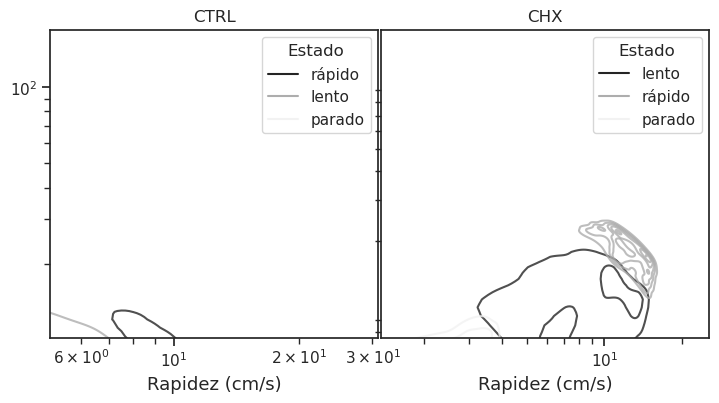

In [47]:
# countour plot of speed vs acceleration, color by state, make a plot for each treatment

fig, ax = plt.subplots(1, 2, figsize=(8.5, 4))
plt.subplots_adjust(wspace=0.01)
tr = {'CTRL': 0, 'CHX': 1}

for treatment, group in df.groupby('treatment'):
    plot_contour = sns.kdeplot(data=group, 
                               x='speed.m/s', y='acceleration.m/s^2',
                               hue='state_class',
                               palette=color,
                               ax=ax[tr[treatment]],
                               alpha=0.8)
    # log scale
    ax[tr[treatment]].set_xscale('log')
    ax[tr[treatment]].set_yscale('log')
    # Getting the legend from the current axes
    legend = plot_contour.get_legend()

    # Setting the title of the legend
    legend.set_title("Estado")

    # Setting the title of the subplot
    ax[tr[treatment]].set_title(treatment)
    ax[tr[treatment]].set_xlabel('Rapidez (cm/s)', fontsize=13)
    if treatment == 'CTRL':
        ax[tr[treatment]].set_ylabel('', fontsize=13)
    else:
        ax[tr[treatment]].set_ylabel('')
        ax[tr[treatment]].set_yticklabels([])
        ax[tr[treatment]].set_yticks([])

In [48]:
# make a function to compute the x limits for the histogram
def custom_histogram(data, bins, threshold=0.05):
    """Make a histogram of data and return the x limits for the histogram
    based on the threshold.
    args:
        data: array-like
            The data to be plotted as a histogram
        bins: int
            The number of bins to use for the histogram
        threshold: float
            The threshold for the proportion of data in a bin. If the proportion
            of data in a bin is greater than or equal to the threshold, then
            the bin is included in the histogram.
        Returns:
            x_min: float
                The minimum x value for the histogram
            x_max: float
                The maximum x value for the histogram

    """
    counts, bin_edges = np.histogram(data, bins=bins)
    proportions = counts / sum(counts)

    x_min, x_max = None, None
    for i, prop in enumerate(proportions):
        if prop >= threshold:
            if x_min is None:
                x_min = bin_edges[i]
            x_max = bin_edges[i + 1]

    return x_min, x_max


def plot_histograms(df, treatment, state_col, state, feature, xlims, feature_map, color, n_bins=30, stat='density', fig_size=(20, 7), save=False, save_path=None):
    """
    Plots histograms of feature values for treated and untreated individuals in a particular state.

    Args:
        df (Dataframe): Dataframe containing the data.
        treatment (str): Name of treatment column in df.
        state_col (str): Name of state column in df.
        state (str): Name of state to filter by.
        feature (str): Name of feature to plot.
        feature_map (dict): Dictionary mapping feature names to human-readable feature labels.
        color (list): List of two colors to use for the histograms.
        n_bins (int): Number of bins to use for the histogram.

    Returns:
        None
    """

    # Set the style of seaborn
    sns.set(style='ticks')

    # Create a figure and axes
    fig, axs = plt.subplots(len(state), len(feature), figsize=fig_size)
    plt.subplots_adjust(wspace=0.2, hspace=0.6)

    # Loop over each state and feature
    for i, st in enumerate(state):

        for j, feat in enumerate(feature):

            # Loop over each treatment and color
            for t, c in zip(treatment, color):
                data = df[(df[state_col] == st) & (
                    df['treatment'] == t)][feat]
                # filter the data between such the limits that are above the
                # 5 % of the counts
                if feat == 'curvature.1/m':
                    data = data[(data > xlims[0]) & (data < xlims[1])]
                sns.histplot(data, bins=n_bins, 
                             stat=stat, 
                             color=c, edgecolor=c, ax=axs[i, j],
                             element='step', fill=True)
            # Set title and legend
            axs[i, j].set_title(f'E: {st}, {feature_map[feat]}', fontsize=9)
            axs[i, j].set_xlabel("")
            axs[i, j].tick_params(axis='both', which='major', labelsize=8)
            # Share x and y labels
            if j == 0:
                axs[i, j].legend(treatment, fontsize=9)
                axs[i, j].set_ylabel('Frecuencia', fontsize=9)
            else:
                axs[i, j].set_ylabel("")
            # if i == len(state) - 1:
            #     axs[i, j].set_xlabel(feature_map[feat])
    if save:
        plt.savefig(save_path, dpi=600, bbox_inches='tight')
    
    plt.show()


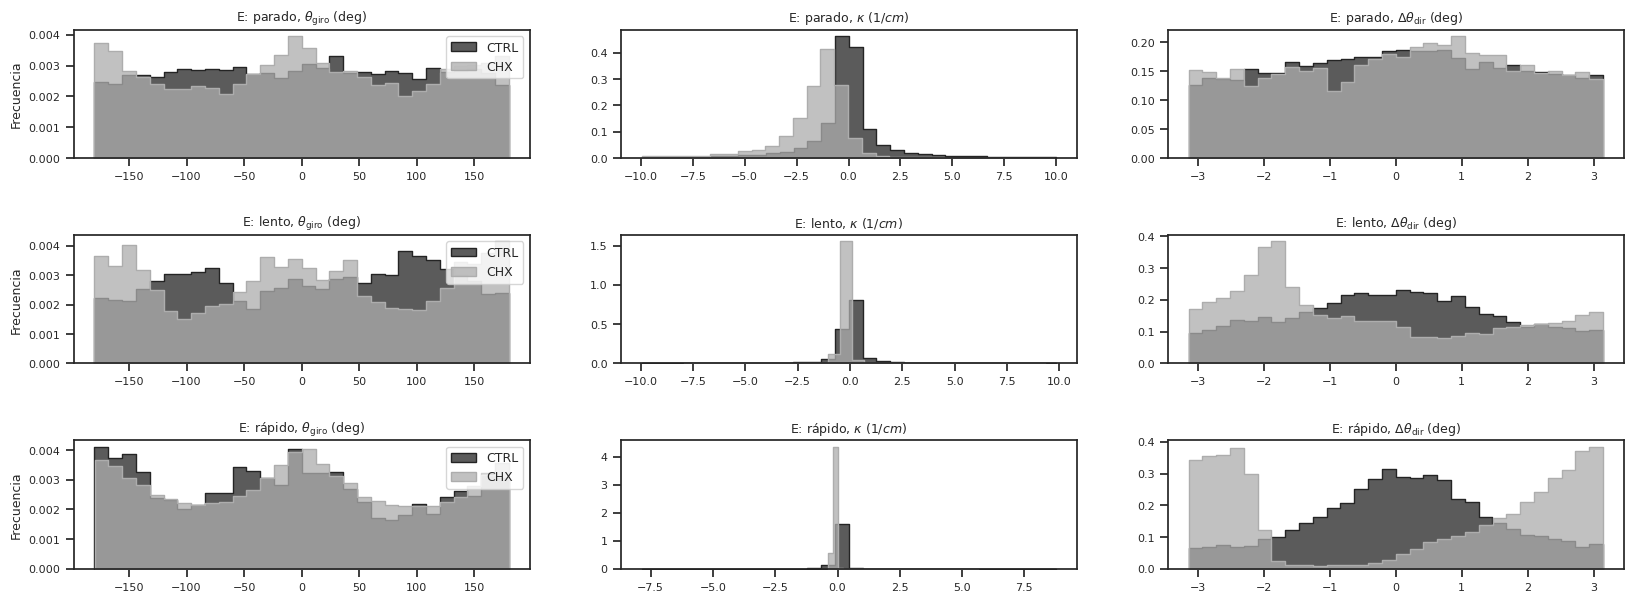

In [49]:
treatment = ['CTRL', 'CHX']
state = ['parado', 'lento', 'rápido']
state_col = 'state_class'
feature = ['turn_angle.deg', 
           'curvature.1/m',
           'change_in_direction',
           ]
# Map of English features to Spanish titles with annotations
feature_map = {
    'turn_angle.deg': r'$\theta_{\mathrm{giro}}$ (deg)',
    'curvature.1/m': '$\\kappa$ ($1/cm$)',
    'change_in_direction': r'$\Delta \theta_{\mathrm{dir}}$ (deg)'
}
color = ['blue', 'orange']

color = ["#242424", "#ADADAD"]
xlims=(-10, 10)
plot_histograms(df, treatment, state_col, state, feature, xlims, feature_map, color)


In [50]:
# Define the number of substates for HMM
n_substates = 3

for treatment, group in df.groupby('treatment'):
    # Select only rows where state_class is 'moving'
    moving_group = group[group['state_class'].isin(['parado', 'lento', 'rápido'])]
    
    if len(moving_group) > 0:  # Check if there is at least one row where state_class is 'moving'
        # Select features
        features = moving_group[['turn_angle.deg', 
                                 'curvature.1/m', 
                                 'change_in_direction']]

        # Train HMM
        model = train_hmm(features, n_substates, tol=1e-2, n_iter=1000)

        # Classify states
        df.loc[(df['treatment'] == treatment) & (df['state_class'].isin(['parado', 'lento', 'rápido'])),
               'substate_hmm_moving'] = classify_states_hmm(model, features)

df.head()

,time,hx.m,hy.m,distance,subject,treatment,date,hx.m_smooth,hy.m_smooth,vx.m/s,...,turn_angle.deg,curvature.1/m,direction,change_in_direction,jerk_x.m/s^3,jerk_y.m/s^3,jerk.m/s^3,state_hmm,state_class,substate_hmm_moving
0,0.041667,20.662596,23.558278,0.000000,TC13,CTRL,MAR_3_AM,20.357475,21.370078,-26.192227,...,-32.649709,0.003297,156.963929,0.000000,158.488356,-101.825453,188.379887,2.0,rápido,0.0
1,0.083333,19.844052,23.632344,0.821888,TC13,CTRL,MAR_3_AM,19.266132,21.834137,-25.631209,...,-32.672817,0.005284,157.193226,0.229297,155.403395,-100.122839,184.864270,2.0,rápido,0.0
2,0.125000,18.955256,23.722375,0.893344,TC13,CTRL,MAR_3_AM,18.221541,22.268239,-24.519884,...,-32.719896,0.008070,157.682872,0.489646,69.989297,-45.804885,83.645616,2.0,rápido,0.0
3,0.166667,18.004624,23.825303,0.956189,TC13,CTRL,MAR_3_AM,17.222808,22.672878,-23.429982,...,-32.792754,0.009242,158.216092,0.533220,-12.339841,6.810455,14.094466,2.0,rápido,0.0
4,0.208333,17.002847,23.937036,1.007988,TC13,CTRL,MAR_3_AM,16.269042,23.048547,-22.361503,...,-32.868435,0.010624,158.798106,0.582014,-12.339841,6.810455,14.094466,2.0,rápido,0.0


In [51]:
def count_full_rotations(traj):
    """
    Counts the number of clockwise and counterclockwise rotations of a noisy moving object,
    given its 2D trajectory.

    Args:
        traj (ndarray): A 2D numpy array of shape (n, 2), representing the x and y
        coordinates of the object's trajectory over time.

    Returns:
        A tuple (cw, ccw) of integers, representing the number of clockwise and counterclockwise
        rotations, respectively.
    """
    # Calculate the angles between consecutive points in the trajectory
    deltas = np.diff(traj, axis=0)
    angles = np.arctan2(deltas[:, 1], deltas[:, 0])

    # Shift the angles to be in range [0, 2*pi]
    angles = np.mod(angles, 2*np.pi)

    # Calculate the differences between consecutive angles
    delta_angles = np.diff(angles)

    # Adjust jumps of 2*pi, indicating a full rotation
    delta_angles = (delta_angles + np.pi) % (2 * np.pi) - np.pi

    # Smooth the delta angles to reduce the effect of noise
    delta_angles = np.convolve(delta_angles, np.ones(5)/5, mode='valid')

    # Start the counts for clockwise and counterclockwise rotations
    cw, ccw = 0, 0
    
    rot_vec = np.zeros(len(delta_angles))

    # Initialize the cumulative angle
    cumulative_angle = 0

    for i, delta_angle in enumerate(delta_angles):
        cumulative_angle += delta_angle

        # If the cumulative angle reaches 2*pi or -2*pi, increment the corresponding count
        if cumulative_angle >= 2*np.pi:
            cw += 1
            # put 1 in rot_vec to indicate a clockwise rotation, at the index of 
            # delta_angle
            rot_vec[i] = 1
            # Subtract 2*pi from the cumulative angle to start a new rotation
            cumulative_angle -= 2*np.pi
        elif cumulative_angle <= -2*np.pi:
            ccw += 1
            rot_vec[i] = 1
            # Add 2*pi to the cumulative angle to start a new rotation
            cumulative_angle += 2*np.pi
    pad = np.abs(len(traj) - len(rot_vec))
    
    return np.pad(rot_vec, (0, pad), 'constant', constant_values=(0, 0))

# add a column to the dataframe with the rotation vector, just for treatment

for tr in df['treatment'].unique():
    df.loc[df['treatment'] == tr, 'rotation_vector'] = count_full_rotations(
        df[df['treatment'] == tr][['hx.m_smooth', 'hy.m_smooth']].values)

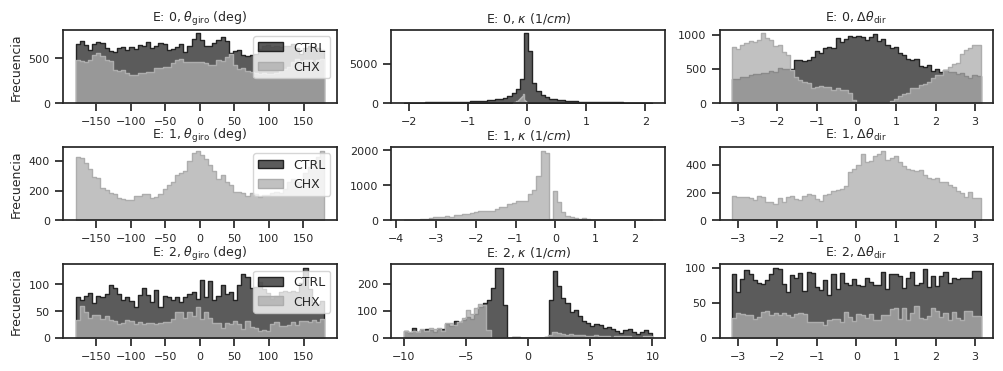

In [52]:
# # plot the histogram of speed, acceleration, turn_ange and curvature for each substate

treatment = ['CTRL', 'CHX']
substate = [0, 1, 2]
feature = ['turn_angle.deg',
           'curvature.1/m',
           'change_in_direction']
# Map of English features to Spanish titles with annotations
feature_map = {
    'turn_angle.deg': r'$\theta_{\mathrm{giro}}$ (deg)',
    'curvature.1/m': '$\\kappa$ ($1/cm$)',
    'change_in_direction': r'$\Delta \theta_{\mathrm{dir}}$'
}

color = ["#242424", "#ADADAD", "#E6E6E6"]

state_col = 'substate_hmm_moving'
df_moving = df[df['state_class'].isin(['parado','lento', 'rápido'])]
xlims=(-10, 10)
plot_histograms(df_moving, treatment, state_col,
                substate, feature, xlims, feature_map, color, 
                n_bins=60, stat='count', fig_size=(12, 4),
                save=True, save_path='histogramas_subestados_movimiento.png')


In [53]:
# agrupar por tratamiento y subestado, y sumar el vector de rotaciones
df.groupby(['treatment', 'substate_hmm_moving'])['rotation_vector'].sum().reset_index()

,treatment,substate_hmm_moving,rotation_vector
0,CHX,0.0,196.0
1,CHX,1.0,165.0
2,CHX,2.0,43.0
3,CTRL,0.0,63.0
4,CTRL,1.0,0.0
5,CTRL,2.0,49.0


In [54]:
# import mode from scipy.stats
# from scipy.stats import mode


# def majority_vote(data, window_size):
#     # Compute the majority vote in a moving window
#     return data.rolling(window_size).apply(lambda x: mode(x)[0][0])


# window_size = 100
# # Apply majority vote to the state and substate classifications

# df['state_hmm_mv'] = majority_vote(df['state_hmm'], window_size)


#     df[f'substate_hmm_mv{state}'] = majority_vote(
#         df[f'substate_hmm{state}'], window_size)


In [55]:
# import matplotlib.pyplot as plt

# # Plot the frequency of each state and substate by treatment
# for treatment in df['treatment'].unique():
#     fig, axs = plt.subplots(1, 2, figsize=(10, 5))

#     df[df['treatment'] == treatment]['state_hmm_mv'].value_counts().plot(
#         kind='bar', ax=axs[0])
#     axs[0].set_title(f'State frequency for {treatment} treatment')

#     df[df['treatment'] == treatment]['substate_hmm_mv'].value_counts().plot(
#         kind='bar', ax=axs[1])
#     axs[1].set_title(f'Substate frequency for {treatment} treatment')

#     plt.tight_layout()
#     plt.show()


In [56]:
# obtaind how much nan values are in each column by treatment and state class
df.groupby(['treatment', 'state_class']).apply(lambda x: x.isna().sum())

time  hx.m  hy.m  distance  subject  treatment  date  \
treatment state_class                                                         
CHX       lento           0     0     0         0        0          0     0   
          parado          0     0     0         0        0          0     0   
          rápido          0     0     0         0        0          0     0   
CTRL      lento           0     0     0         0        0          0     0   
          parado          0     0     0         0        0          0     0   
          rápido          0     0     0         0        0          0     0   

                       hx.m_smooth  hy.m_smooth  vx.m/s  ...  curvature.1/m  \
treatment state_class                                    ...                  
CHX       lento                  0            0       0  ...              0   
          parado                 0            0       0  ...              0   
          rápido                 0            0       0  ...              0   
CTRL      lento                  0            0       0  ...              0   
          parado                 0            0       0  ...              0   
          rápido                 0            0       0  ...              0   

                       direction  change_in_direction  jerk_x.m/s^3  \
treatment state_class                                                 
CHX       lento                0                    0             0   
          parado               0                    0             0   
          rápido               0                    0             0   
CTRL      lento                0                    0             0   
          parado               0                    0             0   
          rápido               0                    0             0   

                       jerk_y.m/s^3  jerk.m/s^3  state_hmm  state_class  \
treatment state_class                                                     
CHX       lento                   0           0          0            0   
          parado                  0           0          0            0   
          rápido                  0           0          0            0   
CTRL      lento                   0           0          0            0   
          parado                  0           0          0            0   
          rápido                  0           0          0            0   

                       substate_hmm_moving  rotation_vector  
treatment state_class                                        
CHX       lento                          0                0  
          parado                         0                0  
          rápido                         0                0  
CTRL      lento                          0                0  
          parado                         0                0  
          rápido                         0                0  

[6 rows x 28 columns]

In [57]:
# # Replace numerical labels with actual labels
# state_labels = {1: 'stopped', 0: 'moving'}
# substate_labels = {0: 'irregular', 1: 'circling'}
# df['state_hmm_mv_lab'] = df['state_hmm_mv'].replace(state_labels)
# df['substate_hmm_mv_lab'] = df['substate_hmm_mv'].replace(substate_labels)

# # Plot the frequency of each state and substate by treatment
# for treatment in df['treatment'].unique():
#     fig, axs = plt.subplots(1, 2, figsize=(10, 5))

#     df[df['treatment'] == treatment]['state_hmm_mv_lab'].value_counts().plot(
#         kind='bar', ax=axs[0])
#     axs[0].set_title(f'State frequency for {treatment} treatment')

#     df[df['treatment'] == treatment]['substate_hmm_mv_lab'].value_counts().plot(
#         kind='bar', ax=axs[1])
#     axs[1].set_title(f'Substate frequency for {treatment} treatment')

#     plt.tight_layout()
#     plt.show()


In [58]:
# Save the dataframe with the analysis to a csv file

df.to_csv('analysis2.csv', index=False)
df.head()

,time,hx.m,hy.m,distance,subject,treatment,date,hx.m_smooth,hy.m_smooth,vx.m/s,...,curvature.1/m,direction,change_in_direction,jerk_x.m/s^3,jerk_y.m/s^3,jerk.m/s^3,state_hmm,state_class,substate_hmm_moving,rotation_vector
0,0.041667,20.662596,23.558278,0.000000,TC13,CTRL,MAR_3_AM,20.357475,21.370078,-26.192227,...,0.003297,156.963929,0.000000,158.488356,-101.825453,188.379887,2.0,rápido,0.0,0.0
1,0.083333,19.844052,23.632344,0.821888,TC13,CTRL,MAR_3_AM,19.266132,21.834137,-25.631209,...,0.005284,157.193226,0.229297,155.403395,-100.122839,184.864270,2.0,rápido,0.0,0.0
2,0.125000,18.955256,23.722375,0.893344,TC13,CTRL,MAR_3_AM,18.221541,22.268239,-24.519884,...,0.008070,157.682872,0.489646,69.989297,-45.804885,83.645616,2.0,rápido,0.0,0.0
3,0.166667,18.004624,23.825303,0.956189,TC13,CTRL,MAR_3_AM,17.222808,22.672878,-23.429982,...,0.009242,158.216092,0.533220,-12.339841,6.810455,14.094466,2.0,rápido,0.0,0.0
4,0.208333,17.002847,23.937036,1.007988,TC13,CTRL,MAR_3_AM,16.269042,23.048547,-22.361503,...,0.010624,158.798106,0.582014,-12.339841,6.810455,14.094466,2.0,rápido,0.0,0.0


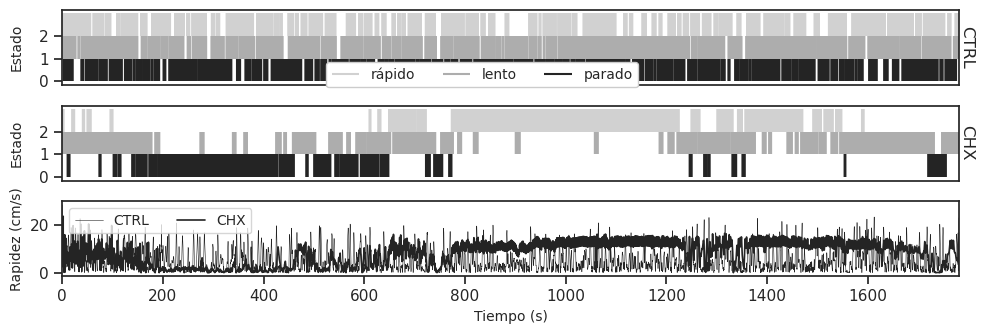

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.read_csv(
    'analysis2.csv')

# map the state class to a numerical value:
# 0 for parado, 1 for lento, 2 for rápido

state_map = {'parado': 0, 'lento': 1, 'rápido': 2}
df['state_hmm'] = df['state_class'].map(state_map)

# df.loc[df['state_class'] == 'moviéndose', 'state_hmm'] = 1
# df.loc[df['state_class'] == 'parado', 'state_hmm'] = 0

color_dict = {'parado': "#242424",
              'lento': "#ADADAD",
              'rápido': "#D1D1D1"}

# Create a figure and axis object
fig, ax = plt.subplots(3, 1, figsize=(10, 3.5))

for i, tr in enumerate(df.treatment.unique()):
    data = df[df['treatment'] == tr]
    # Loop over the unique states in the data
    for state in data.state_hmm.unique():
        state_class = data[data['state_hmm'] == state].state_class.unique()[0]
        # Get the time values for this state
        # if state_class == 'moviéndose':
        #     col = 'black'
        # else:
        #     col = 'grey'
        times = data[data['state_hmm'] == state].time
        # Add the vertical lines to the plot
        ax[i].vlines(times, ymin=state, ymax=state + 1,
                     color=color_dict[state_class],
                     label=f'{state_class}')
    # Set the axis labels and legend

    ax[i].set_xlabel('')
    ax[i].set_xticklabels([])
    ax[i].set_xticks([])
    ax[i].set_ylabel('Estado', fontsize=10, labelpad=11)
    ax[i].set_yticks([0, 1, 2])
    ax[i].set_xlim([0, data.time.max()])
    # put the title at the right
    ax[i].text(1, 0.5, f'{tr}', transform=ax[i].transAxes,
               rotation=270, va='center')
    if i == 0:
        ax[i].legend(bbox_to_anchor=(0.65, 0.4),
                     framealpha=1,
                     ncol=3, fontsize=10)

for treatement in ['CTRL', 'CHX']:
    dftmp = df[df.treatment == treatement]
    ax[2].plot(dftmp['time'], dftmp['speed.m/s'],
               color='#242424',
               linewidth=0.4 if treatement == 'CTRL' else 1.2,
               label=treatement)
ax[2].set_xlabel('Tiempo (s)', fontsize=10)
ax[2].set_ylabel('Rapidez (cm/s)', fontsize=10)
ax[2].set_xlim([0, df.time.max()])
# add legend
ax[2].legend(loc='upper left', ncol=2, fontsize=10)

plt.tight_layout(w_pad=0, h_pad=0.75)
plt.savefig(
    'states_time.png', dpi=600)
plt.show()


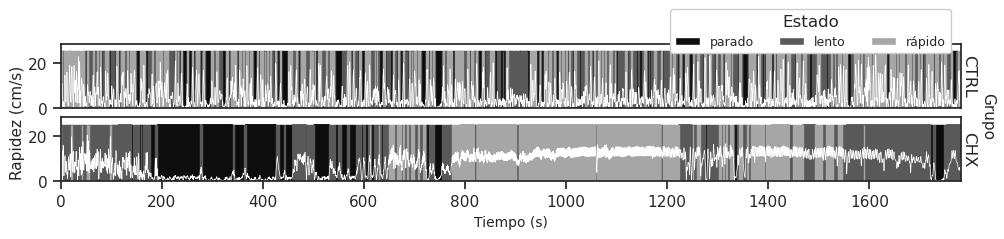

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches


df = pd.read_csv(
    'analysis2.csv')

# map the state class to a numerical value:
# 0 for parado, 1 for lento, 2 for rápido

state_map = {'parado': 0, 'lento': 1, 'rápido': 2}
df['state_hmm'] = df['state_class'].map(state_map)

# df.loc[df['state_class'] == 'moviéndose', 'state_hmm'] = 1
# df.loc[df['state_class'] == 'parado', 'state_hmm'] = 0

color_dict = {'parado': "#0D0D0D",
              'lento': "#595959",
              'rápido': "#A6A6A6"}

# Create a figure and axis object
fig, ax = plt.subplots(2, 1, figsize=(10, 2.5), sharey=True)

for i, treatement in enumerate(df.treatment.unique()):
    dftmp = df[df.treatment == treatement]
    ax[i].plot(dftmp['time'], dftmp['speed.m/s'],
               color='white',
               linewidth=0.5,
               label=treatement)
    for state, color in color_dict.items():
        state_indices = dftmp['state_class'] == state
        ax[i].fill_between(dftmp['time'], 0, 25, where=state_indices,
                            color=color, alpha=1)
    # put the title at the right
    ax[i].text(1, 0.5, f'{treatement}', transform=ax[i].transAxes,
               rotation=270, va='center')
    if i == 0:
        # ax[i].legend(bbox_to_anchor=(0.65, 0.4),
        #              framealpha=1,
        #              ncol=3, fontsize=10)
        ax[i].set_xlabel('')
        ax[i].set_xticklabels([])
        ax[i].set_xticks([])
    else:
        ax[i].set_xlabel('Tiempo (s)', fontsize=10)
    ax[i].set_ylabel('')
    ax[i].set_xlim([0, df.time.max()])
    ax[i].set_ylim([0, df['speed.m/s'].max()])
legend_handles = [mpatches.Patch(facecolor=color, label=state)
                  for state, color in color_dict.items()]
ax[0].legend(handles=legend_handles, bbox_to_anchor=(0.67, 0.75), ncol=3, fontsize=9,framealpha=1, title='Estado')
fig.text(0, 0.5, 'Rapidez (cm/s)', va='center', rotation='vertical', fontsize=11)
fig.text(0.97, 0.525, 'Grupo', va='center', rotation=270, fontsize=11)
plt.tight_layout(w_pad=0, h_pad=0)
plt.savefig(
    'states_time2.png', bbox_inches='tight', dpi=600)
plt.show()

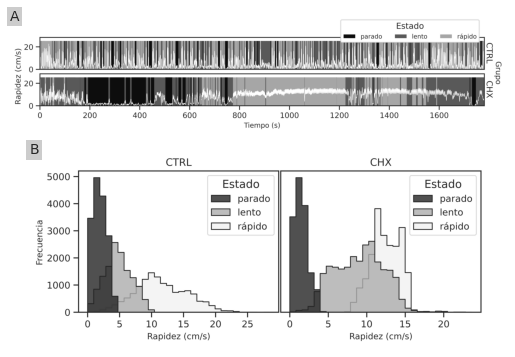

In [69]:
# Multiplot
import matplotlib.pyplot as plt
import matplotlib.image as imat
import numpy as np

axd1 = plt.figure().subplot_mosaic(
    """
    AAA
    BBB
    """
)
img1 = imat.imread("states_time2.png")
img2 = imat.imread("histograma_velocidad.png")

axd1['A'].imshow(img1)
axd1['B'].imshow(img2)
# ad labels A, B, C
for i, ax in enumerate(axd1.values()):
    ax.text(0, 1.05, chr(65 + i), 
            transform=ax.transAxes,
            fontsize=10, fontweight='medium', va='top',
            bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))
# remove axis, ticks, labels and title
for ax in axd1.values():
    ax.axis('off')
plt.subplots_adjust(wspace=0.05, hspace=-0.1)
plt.savefig('Fig3.png', dpi=600, bbox_inches='tight')

In [62]:
df = pd.read_csv(
    'analysis2.csv')

# state_bool1 = (df['state_class'] == 'moviendose') & (df['treatement'] == 'CHX')
# state_bool2 = (df['state_class'] == 'parado') & (df['treatement'] == 'parado')

df.loc[df['state_class'] == 'moviéndose', 'state_hmm'] = 1
df.loc[df['state_class'] == 'parado', 'state_hmm'] = 0

# sumar state_hmm agrupado por treatment y state_class
df.groupby(['treatment', 'state_class'])['state_hmm'].sum()

treatment  state_class
CHX        lento          35470.0
           parado             0.0
           rápido             0.0
CTRL       lento          13269.0
           parado             0.0
           rápido         26732.0
Name: state_hmm, dtype: float64

In [63]:
df.head()

,time,hx.m,hy.m,distance,subject,treatment,date,hx.m_smooth,hy.m_smooth,vx.m/s,...,curvature.1/m,direction,change_in_direction,jerk_x.m/s^3,jerk_y.m/s^3,jerk.m/s^3,state_hmm,state_class,substate_hmm_moving,rotation_vector
0,0.041667,20.662596,23.558278,0.000000,TC13,CTRL,MAR_3_AM,20.357475,21.370078,-26.192227,...,0.003297,156.963929,0.000000,158.488356,-101.825453,188.379887,2.0,rápido,0.0,0.0
1,0.083333,19.844052,23.632344,0.821888,TC13,CTRL,MAR_3_AM,19.266132,21.834137,-25.631209,...,0.005284,157.193226,0.229297,155.403395,-100.122839,184.864270,2.0,rápido,0.0,0.0
2,0.125000,18.955256,23.722375,0.893344,TC13,CTRL,MAR_3_AM,18.221541,22.268239,-24.519884,...,0.008070,157.682872,0.489646,69.989297,-45.804885,83.645616,2.0,rápido,0.0,0.0
3,0.166667,18.004624,23.825303,0.956189,TC13,CTRL,MAR_3_AM,17.222808,22.672878,-23.429982,...,0.009242,158.216092,0.533220,-12.339841,6.810455,14.094466,2.0,rápido,0.0,0.0
4,0.208333,17.002847,23.937036,1.007988,TC13,CTRL,MAR_3_AM,16.269042,23.048547,-22.361503,...,0.010624,158.798106,0.582014,-12.339841,6.810455,14.094466,2.0,rápido,0.0,0.0


In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def time_spent_in_zones(df, x_col, y_col, time_col, width, height, radius):
    """
    Calculate the time spent in each zone.

    Args:
    df (pandas.DataFrame): DataFrame with the data.
    x_col (str): Name of the x column.
    y_col (str): Name of the y column.
    time_col (str): Name of the time column.
    width (float): Width of the arena.
    height (float): Height of the arena.
    radius (float): Radius of the center zone.

    Returns:
    pandas.DataFrame: DataFrame with time spent in each zone.
    """
    center_x = width / 2
    center_y = height / 2

    # Create dt column
    
    # df['dt'] = df[time_col].diff()
    df = df.copy()
    df.loc[:, 'dt'] = 1/24
    
    # Define zones
    center_zone = (df[x_col] - center_x)**2 + (df[y_col] - center_y)**2 <= radius**2
    north_zone = df[y_col] > center_y
    south_zone = df[y_col] <= center_y
    west_zone = df[x_col] <= center_x
    east_zone = df[x_col] > center_x

    times = {
        'Center': df.loc[center_zone, 'dt'].sum(),
        'Mean_dt': df['dt'].mean(),
        'North-West': df.loc[(north_zone & west_zone & ~center_zone), 'dt'].sum(),
        'North-East': df.loc[(north_zone & east_zone & ~center_zone), 'dt'].sum(),
        'South-West': df.loc[(south_zone & west_zone & ~center_zone), 'dt'].sum(),
        'South-East': df.loc[(south_zone & east_zone & ~center_zone), 'dt'].sum()
    }

    return pd.DataFrame(times, index=[0])


def plot_zones_and_positions(df, x_col, y_col, width, height, radius):
    """
    Plot the arena with the zones and the x, y positions.

    Args:
    df (pandas.DataFrame): DataFrame with the data.
    x_col (str): Name of the x column.
    y_col (str): Name of the y column.
    width (float): Width of the arena.
    height (float): Height of the arena.
    radius (float): Radius of the center zone.
    """
    fig, ax = plt.subplots()

    plt.scatter(df[x_col], df[y_col], s=1, color='black', alpha=0.5)
    # Draw zones
    ax.add_patch(patches.Rectangle((0, 0), width/2, height/2, alpha=0.4, color='red'))  # SW
    ax.add_patch(patches.Rectangle((0, height/2), width/2, height/2, alpha=0.4, color='blue'))  # NW
    ax.add_patch(patches.Rectangle((width/2, 0), width/2, height/2, alpha=0.4, color='green'))  # SE
    ax.add_patch(patches.Rectangle((width/2, height/2), width/2, height/2, alpha=0.4, color='yellow'))  # NE
    circle = plt.Circle((width / 2, height / 2), radius, color='orange', alpha=0.4)  # Center
    ax.add_patch(circle)

    plt.xlim(0, width)
    plt.ylim(0, height)
    plt.grid()
    plt.show()


def treatment_analysis(df, x_col, y_col, time_col, width, height, radius):
    """
    Run the time_spent_in_zones and plot_zones_and_positions functions for each treatment.

    Args:
    df (pandas.DataFrame): DataFrame with the data.
    x_col (str): Name of the x column.
    y_col (str): Name of the y column.
    time_col (str): Name of the time column.
    width (float): Width of the arena.
    height (float): Height of the arena.
    radius (float): Radius of the center zone.

    Returns:
    pandas.DataFrame: DataFrame with time spent in each zone for each treatment.
    """
    results = []
    treatments = df['treatment'].unique()

    for treatment in treatments:
        df_treatment = df[df['treatment'] == treatment]
        times = time_spent_in_zones(df_treatment, x_col, y_col, time_col, width, height, radius)
        times['treatment'] = treatment
        results.append(times)

        print(f'Treatment: {treatment}')
        plot_zones_and_positions(df_treatment, x_col, y_col, width, height, radius)

    return pd.concat(results, ignore_index=True)/home/mrrobot/Documents/GitHub/posdoc_papers/analisis/scripts/



SyntaxError: invalid syntax (1107711290.py, line 107)

Treatment: CTRL


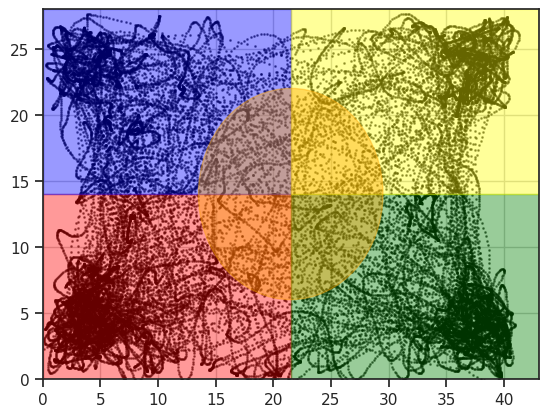

Treatment: CHX


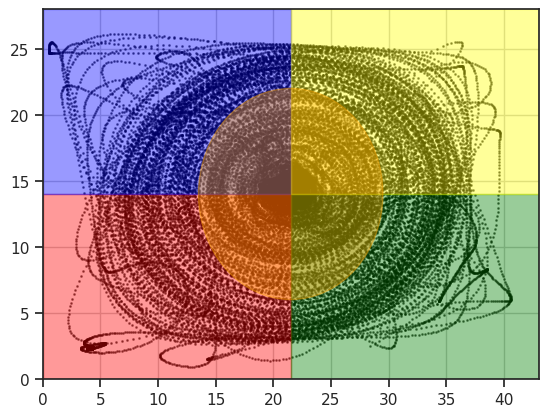

,Center,Mean_dt,North-West,North-East,South-West,South-East,treatment
0,156.708333,0.041667,331.250000,309.500000,568.25,415.291667,CTRL
1,895.041667,0.041667,220.833333,224.791667,233.25,207.083333,CHX


In [ ]:
treatment_analysis(df, x_col='hx.m_smooth', y_col='hy.m_smooth', time_col='time', width=43, height=28,radius=8)

In [ ]:
def count_full_rotations(traj):
    """
    Counts the number of clockwise and counterclockwise rotations of a noisy moving object,
    given its 2D trajectory.

    Args:
        traj (ndarray): A 2D numpy array of shape (n, 2), representing the x and y
        coordinates of the object's trajectory over time.

    Returns:
        A tuple (cw, ccw) of integers, representing the number of clockwise and counterclockwise
        rotations, respectively.
    """
    # Calculate the angles between consecutive points in the trajectory
    deltas = np.diff(traj, axis=0)
    angles = np.arctan2(deltas[:, 1], deltas[:, 0])

    # Shift the angles to be in range [0, 2*pi]
    angles = np.mod(angles, 2*np.pi)

    # Calculate the differences between consecutive angles
    delta_angles = np.diff(angles)

    # Adjust jumps of 2*pi, indicating a full rotation
    delta_angles = (delta_angles + np.pi) % (2 * np.pi) - np.pi

    # Smooth the delta angles to reduce the effect of noise
    delta_angles = np.convolve(delta_angles, np.ones(5)/5, mode='valid')

    # Start the counts for clockwise and counterclockwise rotations
    cw, ccw = 0, 0
    
    rot_vec = np.zeros(len(delta_angles))

    # Initialize the cumulative angle
    cumulative_angle = 0

    for i, delta_angle in enumerate(delta_angles):
        cumulative_angle += delta_angle

        # If the cumulative angle reaches 2*pi or -2*pi, increment the corresponding count
        if cumulative_angle >= 2*np.pi:
            cw += 1
            # put 1 in rot_vec to indicate a clockwise rotation, at the index of 
            # delta_angle
            rot_vec[i] = 1
            # Subtract 2*pi from the cumulative angle to start a new rotation
            cumulative_angle -= 2*np.pi
        elif cumulative_angle <= -2*np.pi:
            ccw += 1
            rot_vec[i] = 1
            # Add 2*pi to the cumulative angle to start a new rotation
            cumulative_angle += 2*np.pi
    pad = np.abs(len(traj) - len(rot_vec))
    
    return cw, ccw, np.pad(rot_vec, (0, pad), 'constant', constant_values=(0, 0))


In [ ]:
start = 14
stop = 15
df_chx = df[df['treatment'] == 'CHX']
df_chx = df_chx[(df_chx['time'] >= start * 60) & (df_chx['time'] <= stop * 60)]

_, _, cum_ang = count_full_rotations(df_chx[['hx.m_smooth', 'hy.m_smooth']])

pad = np.abs(len(df_chx) - len(cum_ang))

df_chx['cum_ang'] = np.concatenate(([0]*pad, cum_ang))
pad

0

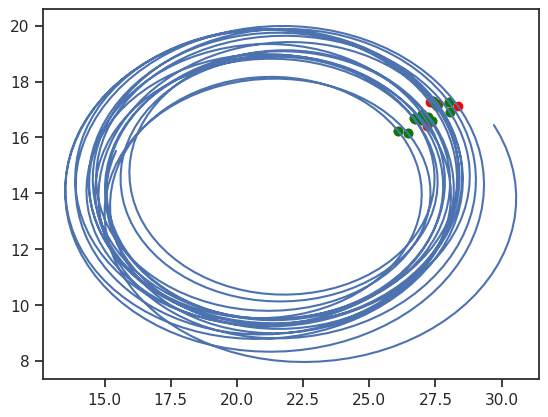

In [ ]:
xy = df_chx[['hx.m_smooth', 'hy.m_smooth', 'cum_ang']].values
plt.plot(xy[:, 0], xy[:, 1])
# add points when cum_ang is 1
plt.scatter(xy[xy[:, 2] == 1, 0], xy[xy[:, 2] == 1, 1], color='red')
# add points just one position before cum_ang is 1
plt.scatter(xy[xy[:, 2] == 1, 0][:-4], xy[xy[:, 2] == 1, 1][:-4], color='green')

In [ ]:
import matplotlib.pyplot as plt

# Function to generate synthetic data
def generate_circular_data(n_rotations=5, noise=0.0001, radius=1, samples_per_rotation=1000):
    angles = np.linspace(0, 2*np.pi*n_rotations, samples_per_rotation*n_rotations)
    data = np.array([radius*np.cos(angles), radius*np.sin(angles)]).T
    data += np.random.normal(scale=noise, size=data.shape)
    return data

# Generate data with 5 rotations
data = generate_circular_data()

# Count the rotations
cw, ccw = count_full_rotations(data)

# Print the results
print(f"Clockwise rotations: {cw}")
print(f"Counterclockwise rotations: {ccw}")

# Plot the data
plt.figure(figsize=(5, 5))
plt.plot(data[:, 0], data[:, 1])
# every 10 points, plot a dot to indicate the start of a rotation
plt.scatter(data[::1000, 0], data[::1000, 1], color='red')
plt.axis('equal')
plt.show()


ValueError: too many values to unpack (expected 2)

In [ ]:
import numpy as np

def count_rotations(traj, sample_rate):
    """
    Counts the number of clockwise and counterclockwise rotations of a moving object,
    given its 2D trajectory.

    Args:
        traj (ndarray): A 2D numpy array of shape (n, 2), representing the x and y
        coordinates of the object's trajectory over time.
        sample_rate (int): The desired sampling rate

    Returns:
        A tuple (cw, ccw) of integers, representing the number of clockwise and counterclockwise
        rotations, respectively.
    """
    # Downsampling the data
    traj = traj[::sample_rate]

    # Calculate the angles between consecutive points in the trajectory
    deltas = np.diff(traj, axis=0)
    angles = np.arctan2(deltas[:, 1], deltas[:, 0])
    
    # Initialize the counts for clockwise and counterclockwise rotations
    cw, ccw = 0, 0

    # Initialize the previous crossing point
    prev_crossing = None

    # Iterate over the trajectory
    for i in range(1, len(traj)):
        # Check if the particle has crossed the horizontal line
        if np.sign(traj[i-1, 1]) != np.sign(traj[i, 1]):
            if prev_crossing is not None:
                # Calculate the change in angle to the crossing point
                delta_angle = angles[i] - angles[prev_crossing]
                # Adjust the change in angle to be in the range [-pi, pi]
                delta_angle = (delta_angle + np.pi) % (2 * np.pi) - np.pi

                # Determine the direction of the rotation
                if delta_angle > 0:
                    ccw += 1
                else:
                    cw += 1

            # Update the previous crossing point
            prev_crossing = i

    return cw, ccw


In [ ]:
count_rotations(df_chx[['hx.m_smooth', 'hy.m_smooth']].values, 2)